**Brian Blaylock**  
**June 26, 2020**  

🌐 HRRR Archive Website: http://hrrr.chpc.utah.edu/  
🚑 Support: atmos-mesowest@lists.utah.edu  
📧 Brian Blaylock: blaylockbk@gmail.com  
✒ Citation this details:
> Blaylock B., J. Horel and S. Liston, 2017: Cloud Archiving and Data Mining of High Resolution Rapid Refresh Model Output. Computers and Geosciences. 109, 43-50. https://doi.org/10.1016/j.cageo.2017.08.005

---

# 🏗 HRRR Download Demo: Part 4
## Opening GRIB2 files in Python with `xarray` and `cfgrib`

- [Part 1: How to download a bunch of HRRR grib2 files (full file)](./demo_download_hrrr_archive_part1.ipynb)
- [Part 2: How to download a subset of variables from a HRRR file](./demo_download_hrrr_archive_part2.ipynb)
- [Part 3: A function that can download many full files, or subset of files](./demo_download_hrrr_archive_part3.ipynb)
- [Part 4: Opening GRIB2 files in Python with xarray and cfgrib](./demo_download_hrrr_archive_part4.ipynb)

---

When it comes to reading GRIB2 files in Python, you have two options: 1) `pygrib` and 2) `cfgrib`. These have recently been made available on the Windows PC, which is aweseom.

The benefit of `cfgrib` is it's ability to read HRRR files as an xarray dataset.


### 📔 **Before you get started, I recommend you review the documentation for [cfgrib](https://github.com/ecmwf/cfgrib) and [xarray](http://xarray.pydata.org/en/stable/).**

---

Note: Instead of putting the long download functions in a cell, I will import the function from the file `HRRR_archive.py`.

In [1]:
import os
import re
from datetime import datetime, timedelta

import numpy as np
import urllib.request  # Used to download the file
import requests        # Used to check if a URL exists
import warnings
import pandas as pd    # Just used for the date_range function
import matplotlib.pyplot as plt

import xarray as xr
import cfgrib

from HRRR_archive import download_HRRR  # HRRR_archive.py needs to me in your current directory or PYTHONPATH

In [2]:
print('cfgrib version:', cfgrib.__version__)
print('xarray version:', xr.__version__)

cfgrib version: 0.9.8.2
xarray version: 0.15.1


I'm just going to work with one GRIB2 file--the six-hour forecast (F06) from the 12:00 UTC 15 June 2020 run for the U and V wind components.

In [3]:
DATE = datetime(2020, 6, 15, 12)
myfile = download_HRRR(DATE, fxx=6, searchString=':(U|V)GRD:10 m')

💡 Info: Downloading 1 GRIB2 files
✅ Success! Searched for [:(U|V)GRD:10 m] and got [2] GRIB fields and saved as ./subset_20200615_hrrr.t12z.wrfsfcf06.grib2

Finished 🍦


In [4]:
myfile

'./subset_20200615_hrrr.t12z.wrfsfcf06.grib2'

Now we can open the file in xarry with the cfgrib engine.

In [5]:
H = xr.open_dataset(myfile, engine='cfgrib')

Ignoring index file '/p/home/blaylock/pyBKB_NRL/demo/HRRR_archive_download/subset_20200615_hrrr.t12z.wrfsfcf06.grib2.4cc40.idx' older than GRIB file


In [6]:
# Let's take a look at what we got...
H

<xarray.Dataset>
Dimensions:            (x: 1799, y: 1059)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  int64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: x, y
Data variables:
    u10                (y, x) float32 ...
    v10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-06-26T22:40:28 GRIB to CDM+CF via cfgrib-0....

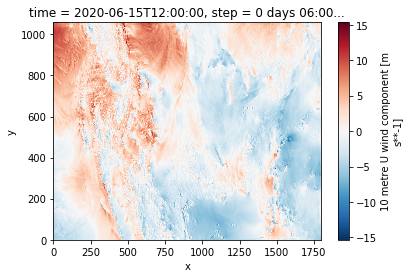

In [7]:
# Plot of u wind component
H.u10.plot()

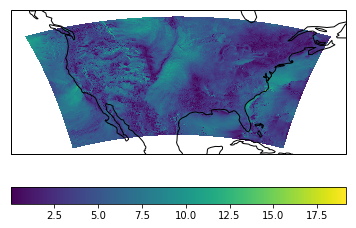

In [8]:
# Compute and plot wind speed with latitude and longitude coordinates on a map

import cartopy.crs as ccrs

ax = plt.subplot(projection=ccrs.PlateCarree())

spd = np.sqrt(H.u10**2 + H.v10**2)

img = ax.pcolormesh(H.longitude, H.latitude, spd, transform=ccrs.PlateCarree())
ax.coastlines()

plt.colorbar(img, ax=ax, orientation='horizontal')

This isn't a demonstration on how to use Cartopy, so I'll leave it up to you to figure that out. There are a lot of good videos from Unidata's [MetPy Monday](https://www.youtube.com/playlist?list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO).

But I will tell you how to get the HRRR model projection information to build your own map on the HRRR's map projection.

In [9]:
# Needs a sample variable DataArray
sH = H[list(H)[0]]

lc_HRRR_kwargs = {
    'globe' : ccrs.Globe(ellipse='sphere'),
    'central_latitude'   : sH.GRIB_LaDInDegrees,
    'central_longitude'  : sH.GRIB_LoVInDegrees,
    'standard_parallels' : (sH.GRIB_Latin1InDegrees, \
                            sH.GRIB_Latin2InDegrees)}

lc = ccrs.LambertConformal(**lc_HRRR_kwargs)
lc

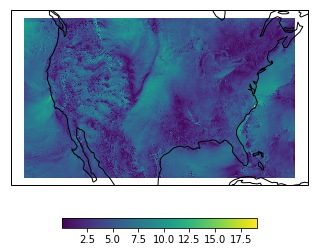

In [10]:
# Now that we have the projection, we can plot the speed

ax = plt.subplot(projection=lc)

img = ax.pcolormesh(H.longitude, H.latitude, spd, transform=ccrs.PlateCarree())
ax.coastlines()

plt.colorbar(img, ax=ax, orientation='horizontal', fraction=0.045)

### Caveats
You should know that cfgrib canot read multiple variables into a Dataset if the fields span different "hypercubes." One example of when this error comes up is if you try to open a GRIB2 file with both 10 meter and 80 meters winds.

In [11]:
myfile = download_HRRR(DATE, searchString=':.GRD:(10 m|80 m)')

💡 Info: Downloading 1 GRIB2 files
✅ Success! Searched for [:.GRD:(10 m|80 m)] and got [4] GRIB fields and saved as ./subset_20200615_hrrr.t12z.wrfsfcf00.grib2

Finished 🍦


In [12]:
H = xr.open_dataset(myfile, engine='cfgrib')

Ignoring index file '/p/home/blaylock/pyBKB_NRL/demo/HRRR_archive_download/subset_20200615_hrrr.t12z.wrfsfcf00.grib2.4cc40.idx' older than GRIB file
skipping variable: paramId==165 shortName='u10'
Traceback (most recent call last):
  File "/p/home/blaylock/anaconda3/envs/basic/lib/python3.7/site-packages/cfgrib/dataset.py", line 588, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/p/home/blaylock/anaconda3/envs/basic/lib/python3.7/site-packages/cfgrib/dataset.py", line 524, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=80) new_value=Variable(dimensions=(), data=10)
skipping variable: paramId==166 shortName='v10'
Traceback (most recent call last):
  File "/p/home/blaylock/anaconda3/envs/basic/lib/python3.7/site-packages/cfgrib/dataset.py", line 588, in build_dataset_components
    dict_merge(variabl

The workaround for this is to use the `cfgrib.open_datasets` function to read the data. This function will attempt to read the data into different xarray Datasets, returned as a list.

> Note: You can turn off the experimental index file creator, as shown in the next cell.

In [13]:
H = cfgrib.open_datasets(myfile, backend_kwargs={'indexpath':''})

The first Dataset, `H[0]`, is the 80 meter wind components. The second Dataset, `H[1]` is the Dataset for 10-meter wind components. Notice that the variable names for the 80-meter winds `u` and `v`, but the variable name for 10-meter winds is `u10` and `v10`.

In [14]:
H[0]

<xarray.Dataset>
Dimensions:            (x: 1799, y: 1059)
Coordinates:
    time               datetime64[ns] 2020-06-15T12:00:00
    step               timedelta64[ns] 00:00:00
    heightAboveGround  int64 80
    latitude           (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude          (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time         datetime64[ns] 2020-06-15T12:00:00
Dimensions without coordinates: x, y
Data variables:
    u                  (y, x) float32 ...
    v                  (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

In [15]:
H[1]

<xarray.Dataset>
Dimensions:            (x: 1799, y: 1059)
Coordinates:
    time               datetime64[ns] 2020-06-15T12:00:00
    step               timedelta64[ns] 00:00:00
    heightAboveGround  int64 10
    latitude           (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude          (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time         datetime64[ns] 2020-06-15T12:00:00
Dimensions without coordinates: x, y
Data variables:
    u10                (y, x) float32 ...
    v10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

---
## 🎉 Here's something useful...A download-and-return-as-xarry function

In the `HRRR_archive.py` script, I included a function called `get_HRRR` that downloads HRRR data from the archive and return it as an xarray Dataset (or list of Datasets). It has some bells and whistles you might need, including adding an attribute for the cartopy projection information.

    from HRRR_archive import get_HRRR

In [16]:
from HRRR_archive import get_HRRR

In [17]:
xH = xhrrr(DATE, ".GRD:.0 m", fxx=0, verbose=False)
xH

/p/home/blaylock/pyBKB_NRL/demo/HRRR_archive_download/HRRR_archive.py:535: UserWarning: ⚠ ALERT! Could not load grib2 data into a single xarray Dataset. You might consider refining your `searchString` if you are getting data you do not need.
  warnings.warn('⚠ ALERT! Could not load grib2 data into a single xarray Dataset. You might consider refining your `searchString` if you are getting data you do not need.')


[<xarray.Dataset>
 Dimensions:            (x: 1799, y: 1059)
 Coordinates:
     time               datetime64[ns] 2020-06-15T12:00:00
     step               timedelta64[ns] 00:00:00
     heightAboveGround  int64 80
     latitude           (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
     longitude          (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
     valid_time         datetime64[ns] 2020-06-15T12:00:00
 Dimensions without coordinates: x, y
 Data variables:
     u                  (y, x) float32 -4.367609 -4.367609 ... 1.257391 1.132391
     v                  (y, x) float32 -4.9180965 -4.9180965 ... -2.6055965
 Attributes:
     GRIB_edition:            2
     GRIB_centre:             kwbc
     GRIB_centreDescription:  US National Weather Service - NCEP 
     GRIB_subCentre:          0
     Conventions:             CF-1.7
     institution:             US National Weather Service - NCEP 
     crs:                     <cartopy.crs.LambertConformal object at 0x2b

---

### What happens if we open a full HRRR file?

To do that, we can use the `cfgrib.open_datasets` function. It will attempt to read all the fields on different types of levels into its own Dataset. 

This can take some time and a lot of disk space. All that work for a lot of data that we are not interested in. Hopefully this convinces you that you probably don't need to download full HRRR files. Instead, if you download just the variables you need you will have much better performance.

In [18]:
# Download a full HRRR file. Save the filename to the variable `myfile`.
DATE = datetime(2020, 6, 15, 12)

myfile = download_HRRR(DATE, fxx=6)

💡 Info: Downloading 1 GRIB2 files
✅ Success! Downloaded https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200615/hrrr.t12z.wrfsfcf06.grib2 as ./20200615_hrrr.t12z.wrfsfcf06.grib2

Finished 🍦


In [19]:
HRRR = cfgrib.open_datasets(myfile, backend_kwargs={'indexpath':''})

### ⏱ Yeah, that took a *long* time to load. 

The output is a list of xarray datasets, each dataset for a different type of level. There are 34 differnt xarray Datasets...

In [20]:
len(HRRR)

34

Let's just look at the `HRRR[6]`, which happens to be the variables at 2 m above ground level.

In [21]:
HRRR[6]

<xarray.Dataset>
Dimensions:            (x: 1799, y: 1059)
Coordinates:
    time               datetime64[ns] 2020-06-15T12:00:00
    step               timedelta64[ns] 06:00:00
    heightAboveGround  int64 2
    latitude           (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude          (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time         datetime64[ns] 2020-06-15T18:00:00
Dimensions without coordinates: x, y
Data variables:
    pt                 (y, x) float32 ...
    q                  (y, x) float32 ...
    t2m                (y, x) float32 ...
    d2m                (y, x) float32 ...
    r2                 (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP